# HW#1: Extreme Rainfall Deficit in Singapore 

```{admonition} Objectives
:class: tip

This homework will help you gain a better understanding in terms of the ways how to:
* Fit Generalized Extreme Value (GEV) distribution 
* Estimate the return level of extreme rainfall deficit

Happy coding!
```

```{admonition} Submission Guide

Deadline: **Sunday 11:59 pm, 3rd November 2024** 
(Note: Late submissions will not be accepted). 

Please upload your solutions to [Canvas](https://canvas.nus.edu.sg/courses/61921/assignments) in a Jupyter Notebook format with the name "Homework1_StudentID.ipynb". Make sure to write down your student ID and full name in the cell below. 

For any questions, feel free to contact Prof. Xiaogang HE ([hexg@nus.edu.sg](mailto:hexg@nus.edu.sg)), Haoling CHEN ([h.chen@u.nus.edu](mailto:h.chen@u.nus.edu)) or Meilian LI ([limeilian@u.nus.edu](mailto:limeilian@u.nus.edu)).

```

In [1]:
## Fill your student ID and full name below.

# Student ID:
# Full name:

**Data**:
You will need to use the historical (1981-2020) daily total rainfall at Singapore's Changi station for this homework. 
You can create a DataFrame using Pandas by reading file "../../assets/data/Changi_daily_rainfall.csv".

## Q1: Calculate daily rainfall statistics (10 marks)

Calculate the following statistics for daily rainfall during DJF (**D**ecember-**J**anuary-**F**ebruary): (i) mean, (ii) variance, (iii) skewness, and (iv) kurtosis.

Hint: 
- You can filter the daily rainfall time series for DJF using Pandas' boolean filtering method. Details on filtering values can be found in the [Pandas tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/pandas-basic.html).
- DJF spans across two calendar years. Make sure you only include complete DJF seasons. For the period 1891 to 2020, this results in 39 complete DJF seasons, from DJF 1981-1982 to DJF 2019-2020.

In [2]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.stats import genextreme as gev

In [9]:
rain = pd.read_csv('../../assets/data/Changi_daily_rainfall.csv', index_col = 0, header = 0, parse_dates = True)
display(rain.head(10))

,Daily Rainfall Total (mm)
Date,
1981-01-01,0.0
1981-01-02,0.0
1981-01-03,0.0
1981-01-04,0.0
1981-01-05,0.0
1981-01-06,0.3
1981-01-07,51.4
1981-01-08,0.0
1981-01-09,4.4


In [3]:
# Filter daily rainfall for December-January-February (DJF)
DJF_rain = rain.loc[(rain.index.month < 3) | (rain.index.month > 11)]
# Select the complete DJF periods
DJF_rain = DJF_rain.loc['19811201':'20200301']
# Calculate the following statistics for daily rainfall during DJF: (i) mean; (ii) variance; (iii) skewness; and (iv) kurtosis.
DJF_rain_stats = pd.Series([
                            DJF_rain.mean().values[0], 
                            DJF_rain.var().values[0], 
                            DJF_rain.skew().values[0], 
                            DJF_rain.kurtosis().values[0]],
                            index=['Mean', 'Variance', 'Skewness', 'Kurtosis']
                            )
display(DJF_rain_stats)

Mean          7.203409
Variance    340.698022
Skewness      4.909512
Kurtosis     33.412606
dtype: float64

## Q2: Fit the GEV distribution (40 marks)

Find the seasonal maximum rainfall deficit for DJF, based on the 30-day centered moving average rainfall deficit. This will result in a data set of 39 values, one value for each year. Fit a GEV distribution to the time series of seasonal maximum rainfall deficits. To do this, estimate the GEV parameters using (i) Maximum Likelihood and (ii) L-Moments, respectively. (Details on fitting a GEV distribution can be found in the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html))

Hint: The rainfall deficit is calculated by subtracting the 30-day moving average rainfall from the mean rainfall calculated in Q1.


In [6]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [11]:
# Add 'Year' column to denote the year of the days
DJF_rain['Year'] = np.where(DJF_rain.index.month==12, DJF_rain.index.year.values, DJF_rain.index.year.values-1)
# Calculate the 30-day moving average for each year
DJF_rain_ma = DJF_rain.groupby(['Year']).rolling(30, center=True).mean()
DJF_rain_ma = DJF_rain_ma.dropna(subset='Daily Rainfall Total (mm)')
DJF_rain_ma.rename(columns={'Daily Rainfall Total (mm)': '30-day Moving Average Rainfall (mm)'}, inplace=True)


In [65]:
# Calculate the 30-day moving average rainfall deficit
DJF_rain_def = DJF_rain['Daily Rainfall Total (mm)'].mean() - DJF_rain_ma 
DJF_rain_def.columns = ['30-day Moving Average Rainfall Deficit (mm)'] 
display(DJF_rain_def)

30-day Moving Average Rainfall Deficit (mm)
Year Date                                                   
1981 1981-12-16                                    -5.286591
     1981-12-17                                    -5.099924
     1981-12-18                                    -5.616591
     1981-12-19                                    -6.663258
     1981-12-20                                    -4.976591
...                                                      ...
2019 2020-02-11                                     3.170076
     2020-02-12                                     4.436742
     2020-02-13                                     4.436742
     2020-02-14                                     5.036742
     2020-02-15                                     5.036742

[2389 rows x 1 columns]

In [64]:
# Calculate the maximum deficit for each year
DJF_max_def = pd.DataFrame(DJF_rain_def['30-day Moving Average Rainfall Deficit (mm)'].groupby('Year').max())
DJF_max_def.columns = ['DJF Maximum Rainfall Deficit (mm)']
DJF_max_def.head()

,DJF Maximum Rainfall Deficit (mm)
Year,
1981,7.040076
1982,7.016742
1983,2.786742
1984,5.956742
1985,6.306742


In [66]:
# Fit the distribution using MLE
cMLE, locMLE, scaleMLE = gev.fit(DJF_max_def, method = "MLE")
MLEGEV = gev(cMLE, loc = locMLE, scale = scaleMLE) 

In [67]:
# Calculate L-moments based on samples
def samlmom3(sample):
    """
    samlmom3 returns the first three L-moments of samples
    sample is the 1-d array
    n is the total number of the samples, j is the j_th sample
    """
    n = len(sample)
    sample = np.sort(sample.reshape(n))[::-1]
    b0 = np.mean(sample)
    b1 = np.array([(n - j - 1) * sample[j] / n / (n - 1)
                   for j in range(n)]).sum()
    b2 = np.array([(n - j - 1) * (n - j - 2) * sample[j] / n / (n - 1) / (n - 2)
                   for j in range(n - 1)]).sum()
    lmom1 = b0
    lmom2 = 2 * b1 - b0
    lmom3 = 6 * (b2 - b1) + b0

    return lmom1, lmom2, lmom3

def pargev_fsolve(lmom):
    """
    pargev_fsolve estimates the parameters of the Generalized Extreme Value 
    distribution given the L-moments of samples
    """
    lmom_ratios = [lmom[0], lmom[1], lmom[2] / lmom[1]]
    f = lambda x, t: 2 * (1 - 3**(-x)) / (1 - 2**(-x)) - 3 - t
    G = fsolve(f, 0.01, lmom_ratios[2])[0]
    para3 = G
    GAM = math.gamma(1 + G)
    para2 = lmom_ratios[1] * G / (GAM * (1 - 2**-G))
    para1 = lmom_ratios[0] - para2 * (1 - GAM) / G
    return para1, para2, para3

In [68]:
# Fit the distribution using LMM
LMM = samlmom3(DJF_max_def.values)
locLMM, scaleLMM, cLMM = pargev_fsolve(LMM)
LMMGEV = gev(cLMM, loc=locLMM, scale=scaleLMM) 

In [69]:
print('Parameters fitted by Maximum Likelihood: shape={:.3f}, loc={:.3f}, scale={:.3f}\n'
      .format(cMLE, locMLE, scaleMLE,))
print('Parameters fitted by L-Moments: shape={:.3f}, loc={:.3f}, scale={:.3f}\n'
      .format(cLMM, locLMM, scaleLMM))

Parameters fitted by Maximum Likelihood: shape=1.082, loc=5.252, scale=2.104

Parameters fitted by L-Moments: shape=0.945, loc=5.164, scale=2.052



## Q3: Estimate the return level of the extreme events (20 marks)

Using the GEV parameters estimated with L-Moments in Q2, estimate the rainfall deficit for events with return periods of 50 years, 100 years, and 1000 years.

In [14]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [70]:
T = np.arange(2, 1001)
rainDef_lmm = LMMGEV.ppf(1 - 1.0 / T)
rainDef_lmm = pd.DataFrame(rainDef_lmm, index = T, 
                      columns = ["DJF Maximum Rainfall Deficit (mm)"])
rainDef_lmm.index.name = "Return period"

display(rainDef_lmm.loc[[50, 100, 1000]])

,DJF Maximum Rainfall Deficit (mm)
Return period,
50,7.281076
100,7.307344
1000,7.332279


## Q4: Test the goodness-of-fit (30 marks)

In this task, you will compare how different distributions fit the same dataset and interpret the results using both statistical analyses. 
- Repeat the distribution fitting as in Q2, but this time using a [normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) and the Maximum Likelihood method. (5 marks)
- Use the Kolmogorov-Smirnov (KS) test to evaluate the goodness-of-fit for both the normal distribution and the GEV distribution you obtained in Q2. (Details on the KS test can be found in the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html)) (10 marks)
- Based on the KS test results, discuss how well each distribution (Normal and GEV) fits the data. (15 marks)

**Bonus (10 marks):**
- Plot the CDF (Cumulative Distribution Function) to visually compare the fitted normal distribution, the GEV distribution from Q2, and the empirical distribution derived from the data. Compare the behavior of the two distributions at different return periods. Are the KS statistic results consistent with your observations from the CDF plot?


Hint: You can reuse the empirical distribution estimation and CDF plotting code from the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html).

In [16]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [17]:
# Fit the normal distribution using MLE
from scipy.stats import norm
locMLE, scaleMLE = norm.fit(DJF_max_def, method = "MLE")
MLEnorm = norm(loc = locMLE, scale = scaleMLE) 

In [18]:
from scipy.stats import kstest
GEVKS = kstest(DJF_max_def["DJF Maximum Rainfall Deficit (mm)"], MLEGEV.cdf)
print('Goodness-of-fit for GEV distribution: statisic is {:.3f}, pvalue is {:.3f}'.format(GEVKS.statistic, GEVKS.pvalue))
NORMKS = kstest(DJF_max_def["DJF Maximum Rainfall Deficit (mm)"], MLEnorm.cdf)
print('Goodness-of-fit for Normal dirstribution: statisic is {:.3f}, pvalue is {:.3f}'.format(NORMKS.statistic, NORMKS.pvalue))


Goodness-of-fit for GEV distribution: statisic is 0.077, pvalue is 0.961
Goodness-of-fit for Normal dirstribution: statisic is 0.164, pvalue is 0.217


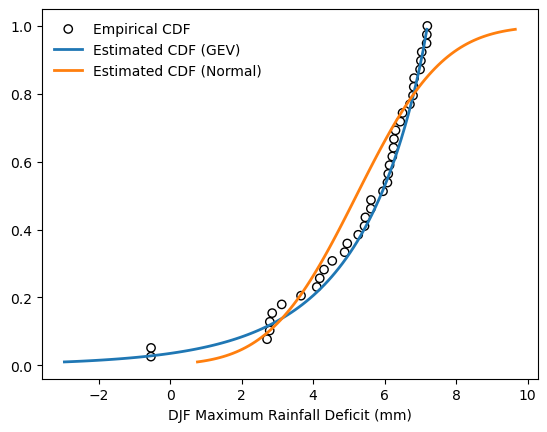

In [19]:
# Plot empirical CDF
plt.scatter(DJF_max_def.sort_values(by = ["DJF Maximum Rainfall Deficit (mm)"]),
            np.arange(1, DJF_max_def.size+1, dtype=float)/DJF_max_def.size,
            color = 'k', facecolors='none', label='Empirical CDF')

# Plot estimated PDF based on maximum likelihood method
bins = np.linspace(MLEGEV.ppf(0.01), MLEGEV.ppf(0.99), 100)
plt.plot(bins, MLEGEV.cdf(bins), 
        lw=2, label='Estimated CDF (GEV)')
# Plot estimated PDF based on the method of L-moments
bins = np.linspace(MLEnorm.ppf(0.01), MLEnorm.ppf(0.99), 100)
plt.plot(bins, MLEnorm.cdf(bins), 
         lw=2, label='Estimated CDF (Normal)')

plt.xlabel("DJF Maximum Rainfall Deficit (mm)")
plt.legend(loc='best', frameon=False)
plt.show()

In [71]:
# GEV distribution describes the data better than the normal distribution. 
# The Kolmogorov-Smirnov test confirms that the GEV distribution fits the data better than the normal distribution, 
# as indicated by a lower KS statistic and a higher p-value.
# The CDF plot provides a visual confirmation of these findings.
# Especially, the normal distribution overestimates the probability of occurrence for moderate rainfall deficits (around 4-6 mm).
# When we move towards longer return periods (more extreme events), the two curves diverge, with GEV distribution providing a better fit.